## Imports

In [148]:
from sklearn.model_selection import train_test_split , ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import random

import backtrader as bt

import matplotlib.pyplot as plt

from tabulate import tabulate

import csv

## Data loading from CSV
### Stockdata
* Load data from CSV

In [196]:
stock_list = pd.read_csv('csv/result_table_1_year_1.csv',sep=',')
u_symbol = stock_list['SYMBOL'].unique()
date = pd.Series(stock_list['Date'])
stock_list.drop(['Date'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))

stock_list

,SYMBOL,1Month,3Months,6Months,1Year,2Years,Week1Prior,Week2Prior,Week3Prior,Month1Prior,Month2Prior,Month3Prior,Month4Prior,Month5Prior,Month6Prior,Month7Prior,Year1Prior,Year2Prior,date
0,ASTS,-0.218286,-0.564571,-0.309714,-0.526857,-0.635429,-0.192804,-0.203822,-0.281609,-0.288039,0.313814,0.337920,0.124679,0.179245,-0.115268,0.388889,-0.242424,-0.138780,2022-09-19
1,PAYC,0.057641,0.041965,-0.049090,0.118102,-0.444451,0.047383,0.107678,0.037890,0.140427,0.095572,0.151175,-0.074116,0.042450,-0.009669,-0.179969,-0.169730,0.167723,2022-08-01
2,LWLG,0.060606,0.146970,0.090909,0.295455,-0.377273,-0.176030,-0.145078,-0.121172,-0.401089,-0.313215,-0.089655,-0.050360,-0.497334,-0.575016,-0.477021,0.527778,7.918919,2022-06-06
3,HUBS,-0.366415,-0.312652,-0.513348,-0.583363,-0.140889,0.037376,-0.086529,-0.149574,-0.103919,-0.162219,-0.078045,-0.014958,0.129480,0.147393,0.353601,0.642656,3.278922,2021-12-23
4,MMAT,-0.293729,-0.442244,-0.495050,-0.547855,-0.976898,-0.111437,-0.098214,-0.266344,-0.364780,-0.392786,-0.407045,0.041237,-0.134286,-0.747078,-0.275120,1.705357,1.104167,2021-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,CCRC,-0.033038,-0.140210,-0.103143,-0.157937,-0.629331,0.251008,0.016380,0.090510,0.035893,0.321619,0.453162,0.411832,-0.376068,-0.328100,-0.250151,-0.108477,-0.119233,2018-11-15
290,SRNEQ,0.369565,0.543478,-0.032609,0.039130,-0.606522,-0.432099,-0.402597,-0.347518,-0.480226,-0.406452,0.260274,1.044444,0.769231,1.628571,1.555556,0.150000,-0.065041,2018-03-28
291,MARK,0.350610,-0.076220,-0.376524,-0.696646,-0.914634,-0.320207,-0.441702,-0.495385,-0.497318,-0.257919,0.935103,1.122977,0.912536,1.385455,1.095847,1.030960,0.623762,2018-02-07
292,IPO.L,-0.065756,-0.294122,-0.108625,-0.241517,-0.507230,-0.004845,-0.051220,0.031400,0.039580,0.010499,0.151426,0.087297,0.004892,0.078351,0.010499,-0.076123,-0.324780,2017-12-18


In [3]:
non_test_variables = ['SYMBOL','1Month','3Months','6Months','1Year','2Years','date']
predict_variables = ['1Month','3Months','6Months','1Year']

print("Number of rows before elimination of NaN: {0}".format(len(stock_list)))
stock_list_1y = stock_list.dropna(subset=["1Year"])
print("Number of rows after elimination of NaN only in 1Years: {0}".format(len(stock_list_1y)))
stock_list_1y = stock_list_1y.dropna(subset=non_test_variables)
print("Number of rows after elimination of NaN only in 1Years and other: {0}".format(len(stock_list_1y)))
stock_list_dropna = stock_list.dropna()
print("Number of rows after elimination of NaN: {0}".format(len(stock_list_dropna)))

Number of rows before elimination of NaN: 294
Number of rows after elimination of NaN only in 1Years: 294
Number of rows after elimination of NaN only in 1Years and other: 294
Number of rows after elimination of NaN: 294


## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* We sort the data before hand and then split it such is guranteed that we dont have future data in our training data. 
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [4]:
# We dont shuffle the array to prevent having future data in training set. 
sorted_stock_list = stock_list_dropna.sort_values(['date'], ascending= True)
train, test = train_test_split(sorted_stock_list, test_size=0.4, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2020-03-09 00:00:00
First date of test data:     2020-03-11 00:00:00
Last date of test data:      2023-01-31 00:00:00


In [5]:
x_train = np.array(train.drop(non_test_variables,axis=1))
y_train = {}
for variable in predict_variables:
    y_train[variable] = np.array(train[variable])

x_test = np.array(test.drop(non_test_variables,axis=1))
y_test ={}
for variable in predict_variables:
    y_test[variable] = np.array(test[variable])

## Train

In [6]:
regressors = {}
for variable in predict_variables: 
    # Define classifier
    clf = xgb.XGBRegressor()
    # Train on trainsplit
    clf.fit(x_train,y_train[variable])
    regressors[variable] = clf

## Predict In and Out-sample

In [7]:
# predict insample
for variable in predict_variables: 
    y_pred_insample = regressors[variable].predict(x_train)
    mse = mean_squared_error(y_pred_insample, y_train[variable])
    print("Mean squared error insample for variable:{0} = {1}".format(variable, mse))

print('\n')

# predict outsample
outsample_predictions = {}
for variable in predict_variables: 
    y_pred_outsample = regressors[variable].predict(x_test)
    y_base_truth = y_test[variable]
    outsample_predictions[variable] = y_pred_outsample
    mse = mean_squared_error(y_pred_outsample, y_test[variable])
    print("Mean squared error outsample for variable:{0} = {1}".format(variable, mse))
#%TODO strategie und plot fixen
#%TODO Strategie auf dem schreiben und testen

Mean squared error insample for variable:1Month = 6.246368445611665e-07
Mean squared error insample for variable:3Months = 7.797490945042628e-07
Mean squared error insample for variable:6Months = 6.099254820282694e-07
Mean squared error insample for variable:1Year = 6.598301902448556e-07


Mean squared error outsample for variable:1Month = 0.09579851017324477
Mean squared error outsample for variable:3Months = 0.7647927422186265
Mean squared error outsample for variable:6Months = 1.0686117468327172
Mean squared error outsample for variable:1Year = 2.377265290035998


## Predict direction
* We are testing if even tho the MSE isn't that great, we can at least predict the direction accuratly
* 1 represents falling 0 is rising

In [8]:
def classifier(x):
    if( x >= 0 ):
        return 0
    else:
        return 1

for variable in predict_variables: 
    classified_predictions = np.array(list(map(classifier, outsample_predictions[variable])))
    classified_y = np.array(list(map(classifier, y_test[variable])))
    print("Accuracy for {0} :".format(variable),metrics.accuracy_score(classified_y,classified_predictions))
    print("Precision for {0} :".format(variable),metrics.precision_score(classified_y, classified_predictions,average="macro"))
    print("Recall for {0} :".format(variable),metrics.recall_score(classified_y, classified_predictions,average="macro"))

# TODO check if 1year and 2year predictions are equally accurate for one stock

Accuracy for 1Month : 0.4830508474576271
Precision for 1Month : 0.4841174707821396
Recall for 1Month : 0.48477011494252875
Accuracy for 3Months : 0.5169491525423728
Precision for 3Months : 0.5067310506292069
Recall for 3Months : 0.5067647058823529
Accuracy for 6Months : 0.4915254237288136
Precision for 6Months : 0.4794226044226044
Recall for 6Months : 0.48061342592592593
Accuracy for 1Year : 0.5254237288135594
Precision for 1Year : 0.5049445609829187
Recall for 1Year : 0.5049445609829187


## Calculate possible returns
* Assuming we enter the market 1 Day after the short selling repport and either short or go long depending on the predictions over two years. 

In [9]:
# Data for the broker
clean_data = pd.read_csv('csv/clean_data_new.csv',sep=',')
u_symbol = clean_data['symbol'].unique()
date = pd.Series(clean_data['datetime'])
clean_data.drop(['datetime'],axis=1,inplace=True)
clean_data['date'] = date.apply(lambda x: np.datetime64(x))

stock_data = {}
for symbol in u_symbol:
    stock_data[symbol] = clean_data[clean_data['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


In [10]:
# Method to find nearest date to a given pivot
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

# Trade simulation with short and long
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a rise it will go long over the period
    * If the regressor predicts a fall it will go short over the period

In [11]:
def trade_long_and_short(test, regressor= regressors['1Year'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(365,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction > 0):
            # long
            profit = exit_price - entry_price
            profit_percentage = profit/ entry_price * 100
        else:
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'long' if prediction > 0 else 'short'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

In [12]:
# Trade with regresor
returns_xgb = trade_long_and_short(test)

### Evaluate Trading
* Compare cumulated profit of random trading with regressor
* Take the average of 100 random runs to have a reliable comparison

In [13]:
def evalute_overall_profit(df):
    total = 0
    positive_trades = 0
    negative_trades = 0
    long_trades = 0
    short_trades = 0 
    profit_long = 0
    profit_short = 0
    total_trades = 0
    for symbol in df: 
        total = total + df[symbol]['profit_percentage']
        if df[symbol]['profit_percentage'] > 0:
            positive_trades += 1
        else:
            negative_trades += 1
    
        if df[symbol]['strategy'] == 'long':
            long_trades += 1
            profit_long += df[symbol]['profit_percentage']
        else:
            short_trades += 1
            profit_short += df[symbol]['profit_percentage']
        total_trades += 1

    return({'total': total, 'positive_trades':positive_trades, 'negative_trades':negative_trades, 
            'long_trades':long_trades, 'short_trades': short_trades,
            'profit_long': profit_long, 'profit_short': profit_short,
            'total_trades': total_trades})

In [14]:
# Run random trading 100 times to get the average profit
avg_profit_rnd = 0
runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade_long_and_short(test,rnd = True))['total']
# avg_profit_rnd = avg_profit_rnd / runs

# run on xgb
xgb_res = list(evalute_overall_profit(returns_xgb).values()) 


print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd,1)))
print("XGB profit: \033[92m{0}%\033[0m \nXGB postive trades: \033[92m{1}\033[0m\nXGB negative trades: \033[92m{2}\033[0m".format(round(xgb_res[0],1),xgb_res[1],xgb_res[2]))
print("XGB amount of long trades: \033[92m{0}\033[0m\nXGB amount of short trades: \033[92m{1}\033[0m".format(xgb_res[3],xgb_res[4]))
print("XGB profit long trades: \033[92m{0}\033[0m\nXGB profit short trades: \033[92m{1}\033[0m".format(round(xgb_res[5],1),round(xgb_res[6],1)))

Random average profit: 0% 
XGB profit: 705.4% 
XGB postive trades: 67
XGB negative trades: 44
XGB amount of long trades: 44
XGB amount of short trades: 67
XGB profit long trades: -1288.9
XGB profit short trades: 1994.3


# Train and test only on 1Year
* Train a regressor on a larger dataset where we only drop rows that have a NaN value in the 1Y 

## Create Testsplit

In [103]:
sorted_stock_list = stock_list_1y.sort_values(['date'], ascending = True)
train_1y, test_1y = train_test_split(sorted_stock_list, test_size=0.4, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2020-03-09 00:00:00
First date of test data:     2020-03-11 00:00:00
Last date of test data:      2023-01-31 00:00:00


In [130]:
x_train_1y = np.array(train_1y.drop(non_test_variables,axis=1))
y_train_1y = np.array(train_1y['1Year'])

x_test_1y = np.array(test_1y.drop(non_test_variables,axis=1))
y_test_1y = np.array(test_1y['1Year'])

## Train
* Train only on 2 Year dataset

In [106]:
# Define classifier
regressor_1y = xgb.XGBRegressor()
# Train on trainsplit
regressor_1y.fit(x_train_1y,y_train_1y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Trade with new regressor & evaluate
* Evaluate performance of 2y Regressor

In [107]:
# Run random trading 100 times to get the average profit
avg_profit_rnd_2y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade(test_2y,rnd = True))['total']
# avg_profit_rnd_2y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_2y,1)))

returns_1y_reg = trade_long_and_short(test_1y, regressor=regressor_1y)
one_y_reg_ret = list(evalute_overall_profit(returns_1y_reg).values())


print("1y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(one_y_reg_ret[0],1),one_y_reg_ret[1],one_y_reg_ret[2]))
print("1y Regressor amount of long trades: \033[92m{0}\033[0m\n2y RegressorXGB amount of short trades: \033[92m{1}\033[0m".format(one_y_reg_ret[3],one_y_reg_ret[4]))
print("1 Regressor profit long trades: \033[92m{0}\033[0m\n2y Regressor profit short trades: \033[92m{1}\033[0m".format(round(one_y_reg_ret[5],1),round(one_y_reg_ret[6],1)))

1y Regressor profit: 705.4% 
2y Regressor postive trades: 67
2y Regressor negative trades: 44
1y Regressor amount of long trades: 44
2y RegressorXGB amount of short trades: 67
1 Regressor profit long trades: -1288.9
2y Regressor profit short trades: 1994.3


# Trade Simulation only short
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a fall it will go short over the period

In [137]:
def trade_short(test, regressor=regressors['1Year'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(365,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction < 0):
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'short' if prediction < 0 else 'long'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        result['exit_date'] = pd.to_datetime(exit_pivot)
        returns[row['SYMBOL']] = result
    return(returns)

In [138]:
# Run random trading 100 times to get the average profit
# avg_profit_rnd_1y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade_short(test_2y,rnd = True))['total']
# avg_profit_rnd_1y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_1y,1)))

returns_1y_reg = trade_short(test_1y, regressor=regressor_1y)
one_y_reg_ret = list(evalute_overall_profit(returns_1y_reg).values())


print("1y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(one_y_reg_ret[0],1),one_y_reg_ret[1],one_y_reg_ret[4]-one_y_reg_ret[1]))
print("1y Regressor amount of short trades: \033[92m{0}\033[0m".format(one_y_reg_ret[4]))
print("1y Regressor skipped trades: \033[92m{0}\033[0m".format(one_y_reg_ret[7]-one_y_reg_ret[4]))
print("1y Regressor total possible trades: \033[92m{0}\033[0m".format(one_y_reg_ret[7]))
print("1y Regressor profit short trades: \033[92m{1}%\033[0m".format(round(one_y_reg_ret[5],1),round(one_y_reg_ret[6],1)))

1y Regressor profit: -31.1% 
2y Regressor postive trades: 40
2y Regressor negative trades: 27
1y Regressor amount of short trades: 67
1y Regressor skipped trades: 44
1y Regressor total possible trades: 111
1y Regressor profit short trades: -31.1%


# Analysis
1) Check how many shorts were corerct and how many we missed

In [95]:
# classified_predictions_1y = np.array(list(map(classifier, regressor_1y.predict(x_test))))
# classified_y_1y = np.array(list(map(classifier, y_test)))
# a = regressor_1y.predict(x_test)
# t = 0
# for c, p in zip(a,y_test):
#     if(c >= 0 and p >= 0):
#         print('true')
#         t += 1
#     else:
#         print('false')
# print(t)

,SYMBOL,1Month,3Months,6Months,1Year,2Years,Week1Prior,Week2Prior,Week3Prior,Month1Prior,Month2Prior,Month3Prior,Month4Prior,Month5Prior,Month6Prior,Month7Prior,Year1Prior,Year2Prior,date
48,AMCR,0.146051,0.292101,0.408346,0.530551,0.479881,-0.181707,-0.171605,-0.205917,-0.251951,-0.226067,-0.242664,-0.168525,-0.147395,-0.193510,-0.167494,-0.202140,-0.186667,2020-03-11
124,HFFG,-0.312629,-0.139752,-0.339545,-0.221532,-0.314700,0.038710,-0.414545,-0.466887,-0.469813,-0.420516,-0.533108,-0.542614,-0.494241,-0.448000,-0.509146,-0.272590,-0.032064,2020-03-24
283,GDS,0.154089,0.513755,0.560409,0.539777,-0.282342,-0.078767,0.072782,0.115720,-0.123636,-0.059276,0.015669,0.141039,0.253495,0.315725,0.312515,0.380903,1.154586,2020-04-06
239,IQ,-0.027168,0.383815,0.373988,0.017341,-0.732370,-0.028090,-0.075361,-0.048928,-0.135432,-0.297319,-0.279767,-0.143564,-0.113730,0.102613,-0.041551,-0.260051,0.054235,2020-04-07
136,EHTH,0.010173,-0.085471,-0.254934,-0.359534,-0.906095,-0.141652,-0.173838,0.110778,-0.141780,-0.005190,0.241606,0.238665,0.456560,1.110275,0.520693,0.705874,6.507180,2020-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,FREY,-0.136283,-0.334513,-0.328319,-0.849558,-0.853097,-0.063018,-0.170946,-0.162342,-0.180566,-0.189383,-0.129430,-0.071487,0.426768,0.637681,0.506667,-0.000884,0.130000,2022-12-12
187,KNW,0.370000,-0.030000,0.170000,-0.250000,-0.250000,-0.333333,-0.425287,-0.386503,-0.386503,-0.378882,-0.481865,-0.565217,-0.532710,-0.401198,-0.342105,-0.494949,-0.236641,2022-12-19
31,SMCI,0.190583,0.384473,2.658775,3.540537,9.799365,-0.080729,-0.061911,-0.098486,-0.151974,-0.094166,0.370988,0.192211,0.128002,0.839659,0.601567,0.683589,1.355452,2023-01-11
152,STEM,0.005470,-0.450766,-0.252735,-0.638950,-0.701313,0.173299,0.036281,-0.042932,-0.191866,-0.334304,-0.252046,-0.475316,-0.448068,0.187013,0.457735,-0.427677,-0.746111,2023-01-12


Amount of 0's: 47
Amount of 1's: 71
Amount of predicted 0's: 47
Amount of predicted 1's: 71


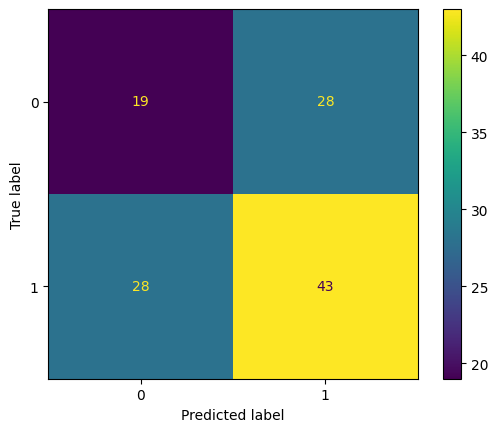

In [136]:
# check how many shorts are correct
classified_predictions_1y = np.array(list(map(classifier, regressor_1y.predict(x_test_1y))))
classified_y_1y = np.array(list(map(classifier, y_test_1y)))
regressor_1y
labels = [0,1]
cm = confusion_matrix(classified_predictions_1y, classified_y_1y,labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
print("Amount of 0's: {0}".format(len(np.where(classified_y_1y == 0)[0])))
print("Amount of 1's: {0}".format(len(np.where(classified_y_1y == 1)[0])))
print("Amount of predicted 0's: {0}".format(len(np.where(classified_predictions_1y == 0)[0])))
print("Amount of predicted 1's: {0}".format(len(np.where(classified_predictions_1y == 1)[0])))


### Saves the result in a csv

In [21]:
# Prints
for entry in returns_1y_reg:
    returns_1y_reg[entry]['symbol'] = entry
with open("result_1-y_reg_only_short.csv", "w", newline="") as f:
    w = csv.DictWriter(f, ['symbol','entry_price', 'exit_price','strategy','profit','profit_percentage','exit_date'])
    w.writeheader()
    for entry in returns_1y_reg:
        w.writerow(returns_1y_reg[entry])

<Axes: >

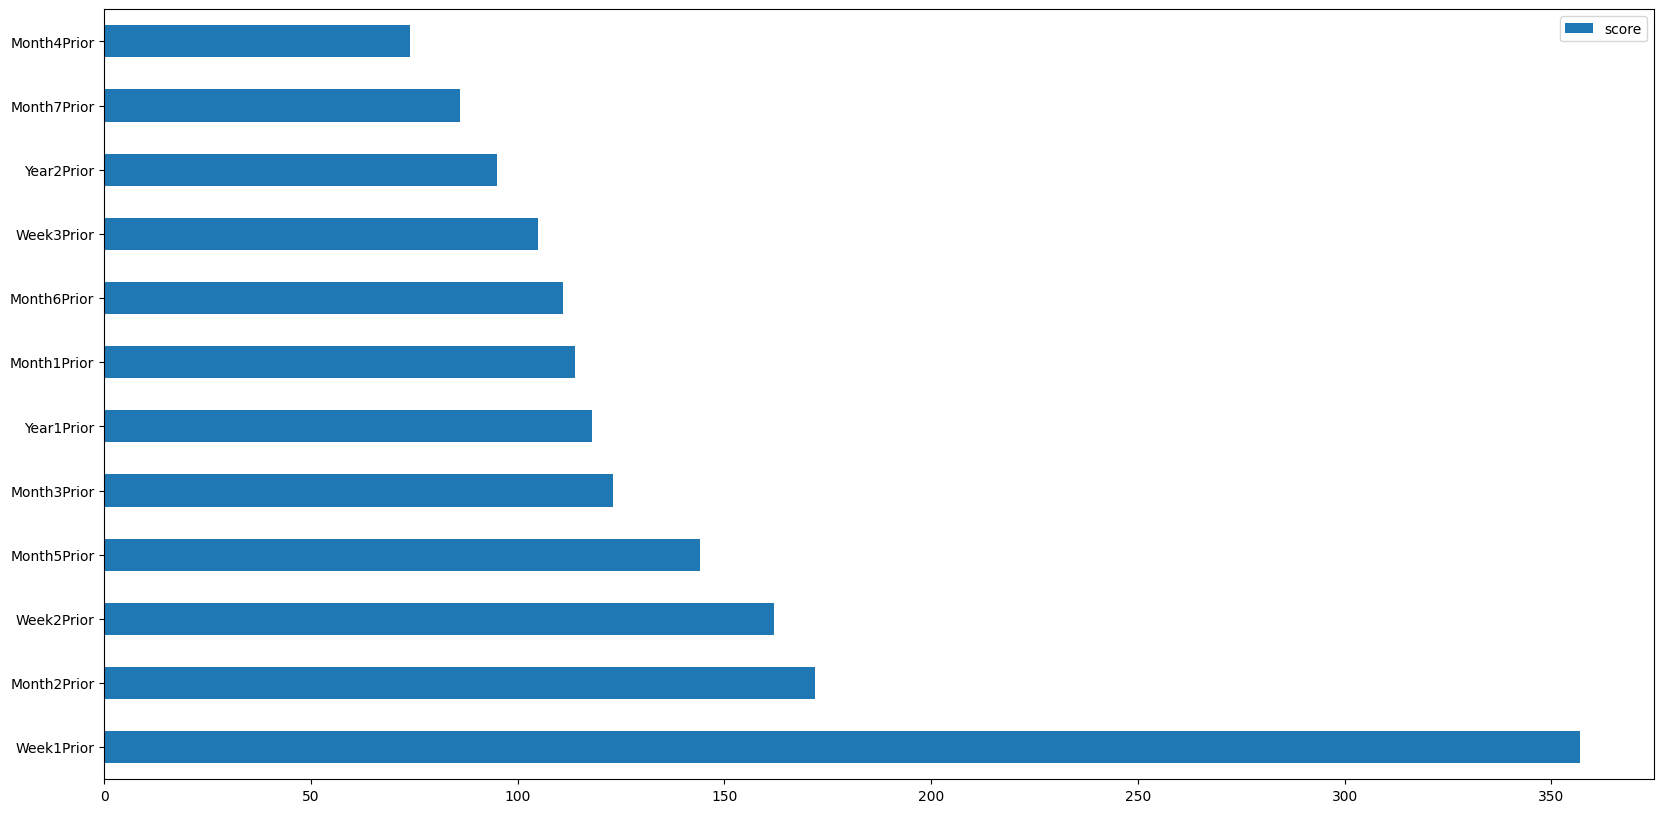

In [22]:
feature_important = regressor_1y.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

feature_names = train_1y.drop(non_test_variables,axis=1).columns.tolist()

data = pd.DataFrame(data=values, index=feature_names, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features